# Abstract

Computer vision, a field of Artificial intelligence offers many capabilities in automating the detection and classification of images. In this project, Three CNN algorithms; AlexNet, ResNet, and simple CNN were experimented for helmet images classification.  Already prepared data from Kaggle, self-taken images and a few freely downloaded images were combined for the project.  

# Introduction

 

Object detection and classification are two important aspects of computer vision. From the earliest manual feature extractor to the feature extractor dominated by deep convolutional networks, object detection has achieved great development and achievements (Zou, et al. 2023). T 

Researchers started paying more attention to CNN (Convolutional Neural Network) in 2012 when AlexNet (Krizhevsky, Sutskever and Hinton, 2012) decisively defeated ImageNet to claim the championship with significant advantages. CNN has had remarkable progress from 2012 to the present in all facets of computer vision, and object identification is no exception. 

Since the development of the conventional CNN, neural networks have become increasingly complex, and several convolutions for minimising computation and parameters have been developed. 

The practises and policies put in place to ensure the physical and mental health of workers while they are working are referred to as safety in the workplace. This entails reducing or getting rid of possible risks like getting exposed to dangerous chemicals, fire, electrical shock, falls, or other physical risks. Any clothing or item of equipment that is intended to shield the wearer from possible workplace hazards is referred to as personal protective equipment (PPE). PPE is designed to stop injuries or illnesses brought on by biological, chemical, or other workplace dangers. Helmets, gloves, eye protection, respiratory protection, and protective clothing like coveralls or aprons are common instances of PPE. When other risk-reduction strategies, such as engineering or administrative controls, are not practical or successful, PPE should be used. 

 

# Problem definition 

 The use of computer vision for PPE detection is an important real-world problem that can significantly enhance workplace safety. Employers can verify that their employees are wearing the proper PPE, lowering the chance of accidents and injuries, and encouraging a safe and healthy work environment by utilising the most recent developments in computer vision and machine learning.  

 Safety helmet identification and classification are accurate and effective when computer vision techniques such as CNNs and object detection methods. They make it possible to identify different types of safety helmets and perform exact localization, boundary box creation, and safety helmet identification. CNNs are useful tools for improving workplace safety through PPE compliance because they can manage differences in lightings and orientations. 

### Aim and objectives 

The aim of this project is to develop a technology that can enhance workplace safety by detecting whether employees are wearing safety helmet or not. 

The following measurable objectives have been identified: 

To understand how object detection techniques works. 

To gather and pre-process a large dataset of images of workers in various work settings, to be used for training the model. 

To gather our own dataset to be used for training and testing the CNN models for classification purposes 

To implement supervised learning approach for the model training. 

To test and evaluate different machine learning model. 

To use a transfer learning method to build the model. 

To analyse and understand the model's false predictions.  

Importing the necessary libraries

In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
import uuid # This wil be to create unique identifiers for our raw data
import os 
import time
import shutil
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader , WeightedRandomSampler
import glob
import matplotlib.patches as patches
import xml.etree.ElementTree as ET

from pathlib import Path
import uuid   # Unique identifier
import os

The next step is to divide the folder of the dataset into train, test and validation

In [2]:
#IMAGES_PATH = os.path.join('raw_data', 'emmanuel') #/data/images
labels = ['red_helmet', 'yellow_helmet','blue_helmet','no_helmet']
number_imgs = 25

### DATA COLLECTION

Datasets sources included: 

 

1.   Safety helmet detection dataset collected from Kaggle [link to the dataset](https://www.kaggle.com/datasets/andrewmvd/hard-hat-detection)  which consists of 5000 images with bounding box annotations in the PASCAL VOC format for these 3 classes: Helmet, Person, Head. 
2.   250 free images online 
3.   400 photos taken by us of different colours, namely: red, blue, and yellow which were bought for the aim of data collection. 300 of these were with safety helmet and 100 without safety helmet. For each safety helmet colour, 100 images were taken on different people to ensure the diversity and the generalisability of our data collection  


 

For the demonstration of the image classification, we only used about 3800 from the images collected from Kaggle after careful selection, in addition to those from the other sources. In total 4799 images have been used for the start of this. 

 For the aim of helmet detection, the 5000 images from Kaggle and their annotations were used along with the 400 self-generated images. The 400 images taken were annotated using labelImg GUI. 
In total 4799 images have been used for the start of this project. 


The photos were taken from different angles and lighting condition to make it realistic and ensure variability. Using the piece of code bellow, we managed to open the camera and perform the data collection from our computer. 

In [3]:
def get_raw_imgs(): 
    #for getting raw images 

    #check if a folder for the image exist's before making it
    data_file = os.path.join(os.getcwd(),'raw_dataky')
    if not os.path.exists(data_file):
        os.mkdir(data_file)
        # for subfolders in ['images','annotations']:
        #     subfolder = os.path.join(data_file,subfolders)
        #     os.mkdir(subfolder)


    IMAGES_PATH = data_file #os.path.join('raw_data','images')

    cap = cv2.VideoCapture(0)
    # Loop through labels
    for label in labels:
        print('Collecting images for {}'.format(label))
        time.sleep(5)

        # Loop through image range
        for img_num in range(number_imgs):
            print('Collecting images for {}, image number {}'.format(label, img_num))

            # Webcam feed
            ret, frame = cap.read()

            # Naming out image path
            imgname = os.path.join(IMAGES_PATH, label+'.'+str(uuid.uuid1())+'.jpg')

            # Writes out image to file 
            cv2.imwrite(imgname, frame)

            # Render to the screen
            cv2.imshow('Image Collection', frame)

            # 2 second delay between captures
            time.sleep(1)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
    cap.release()
    cv2.destroyAllWindows()
    
# Uncomment to get raw images
#get_raw_imgs()


## Imported datasets 

In [4]:
# Importing a dataset:
# For this demonstration we will be using images from a safety helmet https://www.kaggle.com/datasets/andrewmvd/hard-hat-detection
# Ensure the file is in the same path as the notebook.
# Our helmet data will be named as helmet_data

The dataset used in this report is the combination of raw data and downoaded data.
ALL IMAGES AND ANNOTATIONS will be in the "helmet_data" folder

The next step is to divide the folder of the dataset into train, test and validation

In [5]:
dataset_folder = 'helmet_data'
dataset_path = os.getcwd() + '/' + dataset_folder
dataset_path

'C:\\Users\\aeade\\Desktop\\Projects\\Comp vision/helmet_data'

### Image Annotations 
For object detection, annotation is necessary. It helps to assign labels to images, identify relevant objects in the image, and drawing bounding boxes around the object. Fo our project, labelImg GUI was used to create the bounding boxes of our raw data and save the labelling of each image in xml file format, to make our both datasets compatible as the collected dataset from Kaggle has the annotation in xml format.  

In [6]:
# We are going to make annotations from our images with their respective classes
img_path = os.path.join(dataset_path,'images')
#Making a folder where we'll keep the annotations

ann_path = os.path.join(dataset_path,'annotations')
if os.path.exists(ann_path):
    pass
else:
    os.makedirs(dataset_folder + '/annotations',exist_ok = True)


In [7]:
# Using Git to download labelimg
#!git clone https://github.com/tzutalin/labelImg 

# Getting the dependencies for labelimg and launching it to make the annotations
def make_annotations():
    !pip install pyqt5 lxml --upgrade
    !cd labelImg && pyrcc5 -o libs/resources.py resources.qrc
    !cd labelImg && python labelImg.py

# Run this function to use labelimg to make annotations if necessary
#make_annotations()

In [8]:
# making subfolders for split data
os.makedirs(dataset_folder + './train/annotations',exist_ok = True)
os.makedirs(dataset_folder + './train/images',exist_ok = True)
os.makedirs(dataset_folder + './val/annotations',exist_ok = True)
os.makedirs(dataset_folder + './val/images',exist_ok = True)
os.makedirs(dataset_folder + './savedmodel',exist_ok = True)

In [9]:
label_paths = sorted([i for i in Path(ann_path).glob('*.xml')])
images_paths = sorted([i for i in Path(img_path).glob('*.png')]) 

In [10]:
def split_data(image_path,annotation_path, train_percent = 80):
    num_imgs = len(image_path)
    num_train = round((train_percent /100) * num_imgs)
    
    train_images = image_path[:num_train]
    val_images = image_path[num_train:]

    train_labels = annotation_path[:num_train]
    val_labels = annotation_path[num_train:]
               
    return train_images,val_images,train_labels,val_labels

train_images,val_images,train_labels,val_labels = split_data(images_paths,label_paths)


In [11]:
#Copying the images into their respective sets
for i, (path_annot, path_img) in tqdm(enumerate(zip(train_labels, train_images))):
    shutil.copy(img_path +'/'+ path_img.parts[-1], os.path.join(dataset_folder,'./train/images/') + path_img.parts[-1])
    shutil.copy(ann_path +'/'+ path_annot.parts[-1], os.path.join(dataset_folder,'./train/annotations/') + path_annot.parts[-1])
    
for i, (path_annot, path_img) in tqdm(enumerate(zip(val_labels,val_images))):
    shutil.copy(img_path + '/' + path_img.parts[-1], os.path.join(dataset_folder,'./val/images/') + path_img.parts[-1])
    shutil.copy(ann_path + '/' + path_annot.parts[-1],os.path.join(dataset_folder, './val/annotations/' )+ path_annot.parts[-1])

4000it [00:15, 252.07it/s]
1000it [00:03, 258.69it/s]


## Building the customized CNN model

In [12]:
# Installing dependencies
import torch
from torch.nn import CrossEntropyLoss, Conv2d, AvgPool2d, BatchNorm2d, Dropout2d, LeakyReLU, Linear, Module, MaxPool2d,Sequential
from torch.optim import Adam
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18,alexnet  # This is where 
from torchvision.transforms import transforms

import os
from time import time as dur
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from xml.dom.minidom import parse
from shutil import copyfile

In [13]:
# We'll check if our system has a GPU, if not we'll use the CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [14]:
device

device(type='cuda')

In [15]:
#Creating a transformer pipeline to transform our data
# All images will be resized to 128 x 128 and transform them into tensors

transformer = transforms.Compose(
    [transforms.RandomHorizontalFlip(), 
     transforms.Resize((128,128)),
     transforms.RandomRotation(degrees = 10),#
     transforms.ToTensor(), # converting to tensor format
     #transforms.Normalize((0.5,0.5,0.5) , (0.5,0.5,0.5))
    ]) 

In [16]:
# For the CNN operation, the images are stored in their corresponding folders, this function will create folders for the various labels
#Which are the helmet and non helmet

def create_cnn_classes():
    '''
    For the CNN operation, the images are stored in their corresponding folders, this function will create folders for the various labels
    which are the helmet and non helmet
    
    If the folders already exist, this function will not run
    
    '''
    #Splitting data into classes
    cnn_classes = os.path.join(dataset_folder,'cnn_classes')
    helmet_path = os.path.join(dataset_folder,'cnn_classes/helmet present') 
    non_helmet_path = os.path.join(dataset_folder,'cnn_classes/helmet non-present')
    #cnn_helmet_check = os.path.join(dataset_folder + './cnn_classes/train/helmet present')

    if not os.path.exists(helmet_path):
        os.makedirs(dataset_folder + './cnn_classes/helmet present', exist_ok = True)
        os.makedirs(dataset_folder + './cnn_classes/helmet non-present', exist_ok = True)

        for ann_file in tqdm(os.listdir(ann_path)):
            img_name = ann_file.split('.')[0] + '.png'
            labels = os.path.join(ann_path, ann_file)

            dom = parse(labels) #first, we'll parse the xml file so we can interact with it
            root = dom.documentElement
            objects = root.getElementsByTagName("object")

            classes = []
            for box  in objects:
                cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
                classes.append(cls_name)

            if 'helmet' in classes:
                shutil.copy(os.path.join(dataset_folder,'images',img_name), helmet_path)
            else:
                shutil.copy(os.path.join(dataset_folder,'images',img_name), non_helmet_path)
            #print(classes)   

        os.makedirs(dataset_folder + './cnn_classes/train/helmet present', exist_ok = True)
        os.makedirs(dataset_folder + './cnn_classes/train/helmet non-present', exist_ok = True)
        os.makedirs(dataset_folder + './cnn_classes/test/helmet present', exist_ok = True)
        os.makedirs(dataset_folder + './cnn_classes/test/helmet non-present', exist_ok = True)

        split_percent = 80

        num_helmet_train = round(len(os.listdir(helmet_path)) * (split_percent/100))
        num_non_helmet_train = round(len(os.listdir(non_helmet_path)) * (split_percent/100))

        #num_train = round((train_percent /100) * num_imgs)
        helmet_list = os.listdir(helmet_path)
        non_helmet_list = os.listdir(non_helmet_path)

        train_imgs_helmet = helmet_list[:num_helmet_train]
        train_imgs_non_helmet = non_helmet_list[:num_non_helmet_train]

        test_imgs_helmet = helmet_list[num_helmet_train:]
        test_imgs_non_helmet = non_helmet_list[num_non_helmet_train:]

        for pic_h in tqdm(train_imgs_helmet):
            shutil.copy(os.path.join(helmet_path, pic_h) ,  os.path.join(dataset_folder, 'cnn_classes/train/helmet present'))

        for pic_n_h in tqdm(train_imgs_non_helmet):
            shutil.copy(os.path.join(non_helmet_path, pic_n_h) ,  os.path.join(dataset_folder, 'cnn_classes/train/helmet non-present'))

        for pic_h2 in tqdm(test_imgs_helmet):
            shutil.copy(os.path.join(helmet_path, pic_h2) ,  os.path.join(dataset_folder, 'cnn_classes/test/helmet present'))

        for pic_n_h2 in tqdm(test_imgs_non_helmet):
            shutil.copy(os.path.join(non_helmet_path, pic_n_h2) ,  os.path.join(dataset_folder, 'cnn_classes/test/helmet non-present'))

create_cnn_classes()

As demonstrated above, it is possible to automatically split these dataset into their respective class labels using their annotations but for this project, we did the sorting manually and this was used for the model training and annotations were not required for this. The images were classified into train and test and further into helmet and no helmet. 

In [17]:
 os.path.exists('final_dataset/test')

True

In [18]:
train_path = os.path.join(dataset_folder + './cnn_classes/train')
test_path = os.path.join(dataset_folder + './cnn_classes/test')

final_path_train = 'final_dataset/train'
final_path_test = 'final_dataset/test'

# The paths above will be t  our dataset.
# the CNN needs classes, so both train and test will have different folders of the different categories, e.g one for helmets and the other without helmets
# We will use the Imagefolder to load our data

#Uncomment this for data seperated by annotations
# train_dataset = ImageFolder(train_path, transform = transformer)
# test_dataset = ImageFolder(test_path, transform = transformer)

train_dataset = ImageFolder(final_path_train, transform = transformer)
test_dataset = ImageFolder(final_path_test, transform = transformer)

train_len= len(train_dataset)
test_len = len(test_dataset)

In [19]:
# class_weights = [10.94,1]
# sample_weights = [0] * len(train_dataset)

# for idx,(data,label) in enumerate(train_dataset):
#     class_weight = class_weights[label]
#     sample_weights[idx] = class_weight
    
# sampler = WeightedRandomSampler(sample_weights, num_samples = len(sample_weights), replacement = True)


In [20]:
# now to load the images 
# The dataloader will retrieve the features of our dataset a sample at a time i. in batches
# To avoid exceeeding the memory capacity of our GPU or CPU, the images will be uploaded in batches
train_loader = DataLoader(train_dataset, batch_size = 30 , shuffle = True, num_workers = 2)
#train_loader = DataLoader(train_dataset, batch_size = 30 , num_workers = 2,sampler = sampler)
test_loader = DataLoader(test_dataset,batch_size = 30, shuffle = True, num_workers = 2)

In [21]:
train_loader

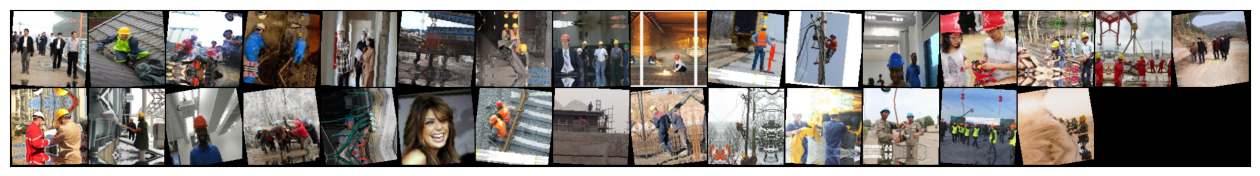

In [22]:
# Showing the pictures in their batches
from torchvision.utils import make_grid

def show_batch(loaded_data = train_loader):
    """Show the image grid of a single batch"""
    for images, labels in loaded_data:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_loader)

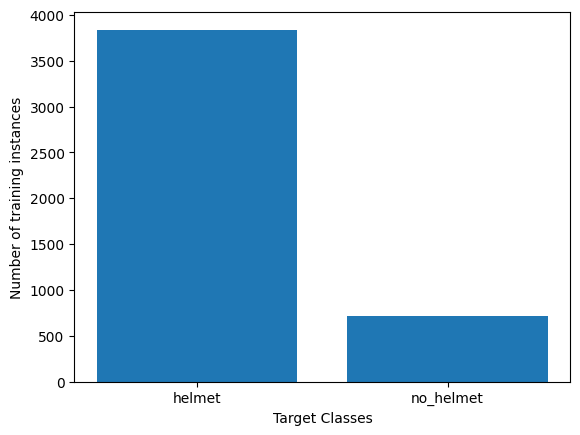

In [23]:
# The data will be trained on similar numbers to help improve the performance
def disp_class_hist (loaded_data = train_loader):   
    classes = []
    for batch_idx, data in enumerate(loaded_data, 0):
        x, y = data 
        classes.extend(y.tolist())

    #Calculating the unique classes and the respective counts and plotting them
    unique, counts = np.unique(classes, return_counts=True)
    names = list(test_dataset.class_to_idx.keys())
    plt.bar(names, counts)
    plt.xlabel("Target Classes")
    plt.ylabel("Number of training instances")
    
disp_class_hist(train_loader)

100%|██████████| 152/152 [00:19<00:00,  7.67it/s]


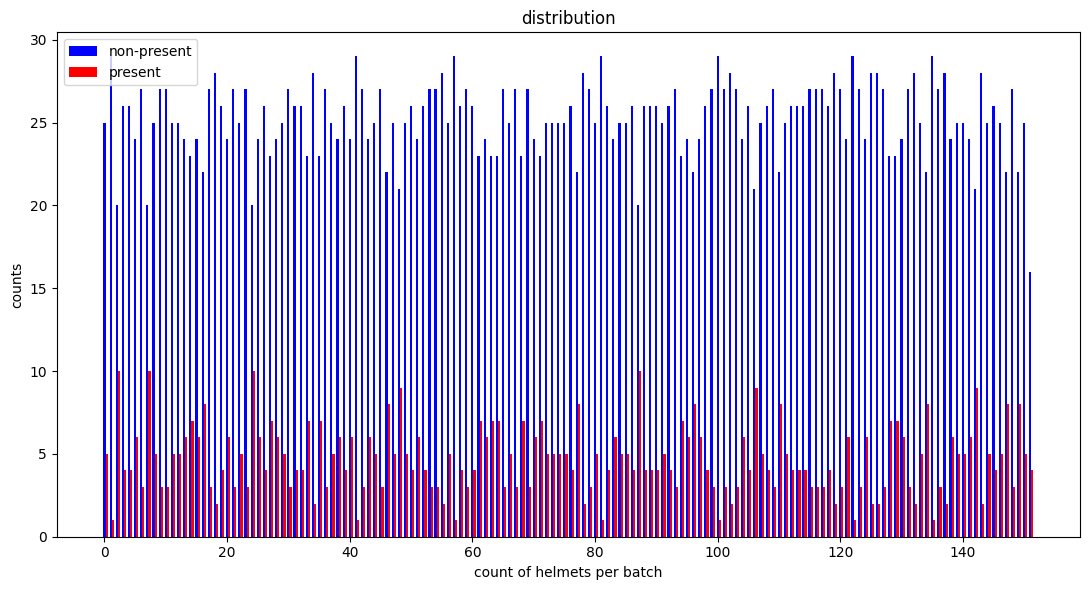

In [24]:
def show_detail_hist(loaded_data = train_loader):
    zeros = []
    ones = []
    for img, label in tqdm(loaded_data):
        lbl = list(label.detach().numpy())
        res, cnts = np.unique(lbl, return_counts=True)
        if len(res) == 2:
            zeros.append(cnts[0])
            ones.append(cnts[1])
        else:
            if res == 0:
                zeros.append(cnts[0])
                ones.append(0)
            else:
                zeros.append(0)
                ones.append(cnts[0])

    num_samples = len(zeros)
    plt.figure(figsize=(11, 6))
    plt.bar(np.arange(len(ones[:num_samples])), zeros[:num_samples], color='b', label='present', width=0.35)
    plt.bar(np.arange(len(ones[:num_samples]))+0.35, ones[:num_samples], color='r', label='non-present', width=0.35)
    plt.xlabel('count of helmets per batch')
    plt.ylabel('counts')
    plt.title('distribution')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
show_detail_hist()

In [25]:
def show_img(im, ax=None, figsize=(8,8), title=None):
    if not ax: _,ax = plt.subplots(1,1,figsize=figsize)
    if len(im.shape)==2: im = np.tile(im[:,:,None], 3) 
    ax.imshow(im);
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    if title: ax.set_title(title)
    return ax

torch.Size([3, 128, 128])


<Axes: >

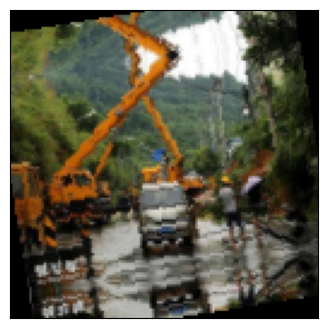

In [26]:
xb, yb = next(iter(train_loader))
print(xb[0].shape)
show_img(xb[0].numpy().transpose(1,2,0), figsize = (4,4))

So the image above has a shape of (3,180,180) therefore theree are 3 channels with height and width of 180

## Building a customized CNN model

### Developed CNN model: 

To get a better understanding of how CNNs works, we implemented a CNN from scratch.  The model was created using PyTorch, it consists of 3 convolutional layers, each one of them is followed by ReLu activation function, which is followed by a max polling.  

The arguments of the convolutional layers are explained in the following: 


**Convolutional layer:**



*   in_channels: is the number of inputs dimension that the model will handle,  
*   out_channels: this represents the output dimension of our model.  
*   kernel_size: this describes the size of the filter that will be applied on the input image. In the first convolutional network this is set to 3 which means that the filter size is 3*3. 
*   Padding: In this instance, padding is set to 1, which adds a one-pixel border with value 0 around the input's edge. Padding can be helpful for maintaining spatial information in the input and preventing information loss at the input's edges. 



**Activation function:** 

the function activates the neuron when the output of the function surpasses the predetermined threshold value. They are in charge of activating the neuron. A non-linearity into the model is introduce by the activation function, this helps the network understand complex structures in the data, such as in the case of images. 

 

*   List itemReLu: according to (OpenGenus IQ: Computing Expertise & Legacy, 2021) Relu it is the most used activation functions specially when it comes CNNs. It is shown to be more effective than the previously introduces functions (sigmoid, tanh), this function returns the value of the input if it is > 0. It returns 0 otherwise  

 

**Polling layer** 


*   Maxpolling: it is done by calculating a maximum value of e piece of a feature map, then uses the value to create a pooled feature map. By minimising the spatial dimensions of the input, max pooling can assist to minimise the number of parameters in the model and avoid overfitting. 
*   Stride: it represents the number of pixels that the filter will be moving through the in both horizontal and vertical way
*   kernel_size; it is the size of the pooling window 


**Flatten layer:**  

It reshapes the output from the previous layer into a 1-dimension tensor fed into the fully connected layer for model classification. 


  

 






In [27]:
# # Building the model 
class convolutional_nn(Module):
    def __init__(self):
        super(convolutional_nn, self).__init__()
        self.model = torch.nn.Sequential(
        
        torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, padding = 1), 
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(stride = 2, kernel_size=2),

        torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3, padding = 1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(stride = 2,kernel_size=2),
            
        torch.nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(stride = 2,kernel_size=2),

        torch.nn.Flatten(),
        torch.nn.Linear(32*16*16, 2),
        #torch.nn.ReLU(),
        #torch.nn.Linear(512, 10)
        )

    def forward(self,x):   
        return self.model(x)

In [28]:
cnn_model = convolutional_nn().to(device)

Two pretrained modes are implemented: AlexNet and ResNet18 in addition to the simple CNN model developed from scratch for the purpose of this study.  

**AlexNet** takes as an input RGB images with size of 227x227 for training, and for testing sets. The architecture is buit from 5 convolutional layers and 3 fully connected layers. Followed by an activation function  Rectified Linear Unit (Relu). (Aqeel Anwar, 2019) 



**ResNet** isn't just one architecture; it's a full family of models. ResNet made a contribution by including residual connections, allowing for the training of significantly deeper models than before (e.g., VGG19 vs. ResNet-152). Almost all CNN designs nowadays (and not only for computer vision problems) make use of residual connections! 

A kind of deep neural network called the AResNet uses skip connections or short-cuts to leap over some layers.ResNet models were introduced in 2015 and won several competition in computer vision. ResNet features structures like those of the cerebral cortex in the brain; it is unclear, however, how many layers there are in the cerebral cortex compared to layers in ResNet and one part of shows the same structure, but they resemble one another quite a deal over broad areas (Yu and Wang). 

In [29]:
#cnn_model = alexnet(pretrained = True).to(device) #for alexnet
# cnn_model = resnet18(pretrained = True) for resnet

In [30]:
# Optimiser
optimiser = Adam(cnn_model.parameters(), lr=3e-4, weight_decay=0.0001)

# Loss Function
loss_function = CrossEntropyLoss()

In [31]:
def train_eval_cnn(tr_l = train_loader, te_l = test_loader):    
#     global train_loader
#     global test_loader
    
    num_epochs = 10

    tr_l = []
    te_l = []
    ep = []
    for epoch in range(num_epochs):
        start = dur()
        train_accuracy = 0
        test_accuracy = 0

    # Train
        
        cnn_model.train()
        #with tqdm(train_loader, unit="batch") as tepoch:
        for x_train, y_train in tqdm(train_loader, unit="batch"):
            optimiser.zero_grad()

            x_train = x_train.to(device)
            train_prob = cnn_model(x_train)
            train_prob = train_prob.cpu()

            train_loss = loss_function(train_prob, y_train)

            train_loss.backward()
            optimiser.step()
            # END TRAIN
            train_pred = torch.max(train_prob, 1).indices
            train_accuracy += int(torch.sum(train_pred == y_train))

        train_epoch_accuracy = train_accuracy / train_len

    # Evaluate
        cnn_model.eval()
        with torch.no_grad():
            for xtest, ytest in test_loader:
                xtest = xtest.to(device)
                test_prob = cnn_model(xtest)
                test_prob = test_prob.cpu()
                test_loss = loss_function(test_prob, ytest)
                test_pred = torch.max(test_prob, 1).indices
                test_accuracy += int(torch.sum(test_pred == ytest))

            test_epoch_accuracy = test_accuracy / test_len

        end = dur()

        duration = end - start


        tr_l.append(train_loss.item())
        te_l.append(test_loss.item())
        ep.append(epoch +1)

        print(f"Epoch: {epoch+1}, Duration: {duration}\nTraining_loss: {train_loss}, Test_loss: {test_loss}\n,Training_accuracy:{train_epoch_accuracy}, Test_accuracy: {test_epoch_accuracy}")
    metrics = {'tr_l':tr_l,'te_l':te_l,'ep':ep}
    return metrics

In [32]:
metrics = train_eval_cnn()

100%|██████████| 152/152 [00:33<00:00,  4.48batch/s]


Epoch: 1, Duration: 42.450433015823364
Training_loss: 0.4207512438297272, Test_loss: 0.20668227970600128
,Training_accuracy:0.8406593406593407, Test_accuracy: 0.8443271767810027


100%|██████████| 152/152 [00:24<00:00,  6.20batch/s]


Epoch: 2, Duration: 32.11224150657654
Training_loss: 0.41298213601112366, Test_loss: 0.3774784207344055
,Training_accuracy:0.8621978021978022, Test_accuracy: 0.9234828496042217


100%|██████████| 152/152 [00:26<00:00,  5.81batch/s]


Epoch: 3, Duration: 33.50958824157715
Training_loss: 0.20384299755096436, Test_loss: 0.2958168685436249
,Training_accuracy:0.9054945054945055, Test_accuracy: 0.9243623570800352


100%|██████████| 152/152 [00:24<00:00,  6.28batch/s]


Epoch: 4, Duration: 31.940900325775146
Training_loss: 0.24427810311317444, Test_loss: 0.26700785756111145
,Training_accuracy:0.9114285714285715, Test_accuracy: 0.9243623570800352


100%|██████████| 152/152 [00:24<00:00,  6.19batch/s]


Epoch: 5, Duration: 31.717193126678467
Training_loss: 0.40763893723487854, Test_loss: 0.28564193844795227
,Training_accuracy:0.9127472527472528, Test_accuracy: 0.9226033421284081


100%|██████████| 152/152 [00:23<00:00,  6.51batch/s]


Epoch: 6, Duration: 30.656620502471924
Training_loss: 0.37392276525497437, Test_loss: 0.23416604101657867
,Training_accuracy:0.9142857142857143, Test_accuracy: 0.9190853122251539


100%|██████████| 152/152 [00:22<00:00,  6.87batch/s]


Epoch: 7, Duration: 29.69460153579712
Training_loss: 0.24395430088043213, Test_loss: 0.12069159746170044
,Training_accuracy:0.916923076923077, Test_accuracy: 0.9199648197009674


100%|██████████| 152/152 [00:24<00:00,  6.25batch/s]


Epoch: 8, Duration: 32.170907974243164
Training_loss: 0.11593298614025116, Test_loss: 0.07140160351991653
,Training_accuracy:0.9156043956043955, Test_accuracy: 0.9261213720316622


100%|██████████| 152/152 [00:27<00:00,  5.52batch/s]


Epoch: 9, Duration: 35.56826305389404
Training_loss: 0.3367639183998108, Test_loss: 0.19180066883563995
,Training_accuracy:0.9145054945054945, Test_accuracy: 0.9270008795074758


100%|██████████| 152/152 [00:23<00:00,  6.38batch/s]


Epoch: 10, Duration: 30.666484355926514
Training_loss: 0.0355236791074276, Test_loss: 0.18426525592803955
,Training_accuracy:0.9171428571428571, Test_accuracy: 0.9261213720316622


In [33]:
def show_metrics(metrics=metrics):    
    fig, ax1 = plt.subplots(figsize=(15,4))
    ax2 = ax1.twinx()
    ax1.plot(metrics['ep'], metrics['tr_l'], 'g-')
    ax2.plot(metrics['ep'], metrics['te_l'], 'b-')

    ax1.set_xlabel('Epoch number')
    ax1.grid('on')
    ax1.set_ylabel('Training loss data', color='g')
    ax2.set_ylabel('Test loss data', color='b')
    #plt.grid(axis='both')

    plt.show()

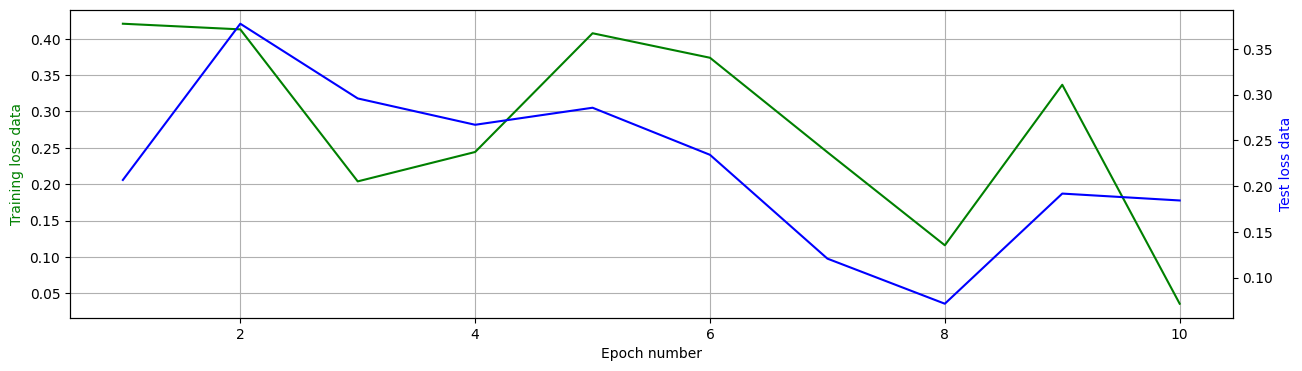

In [34]:
show_metrics(metrics)

## Error Analysis

### Imbalanced dataset

The training whole proces executed above was done on an imbalanced training data which can result in inaccue=rate predictions

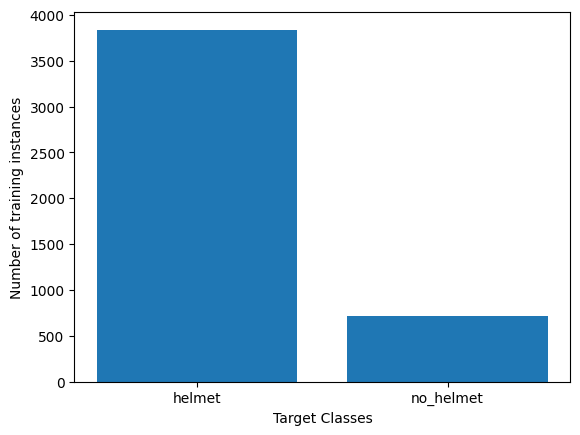

In [35]:
disp_class_hist()

100%|██████████| 152/152 [00:20<00:00,  7.40it/s]


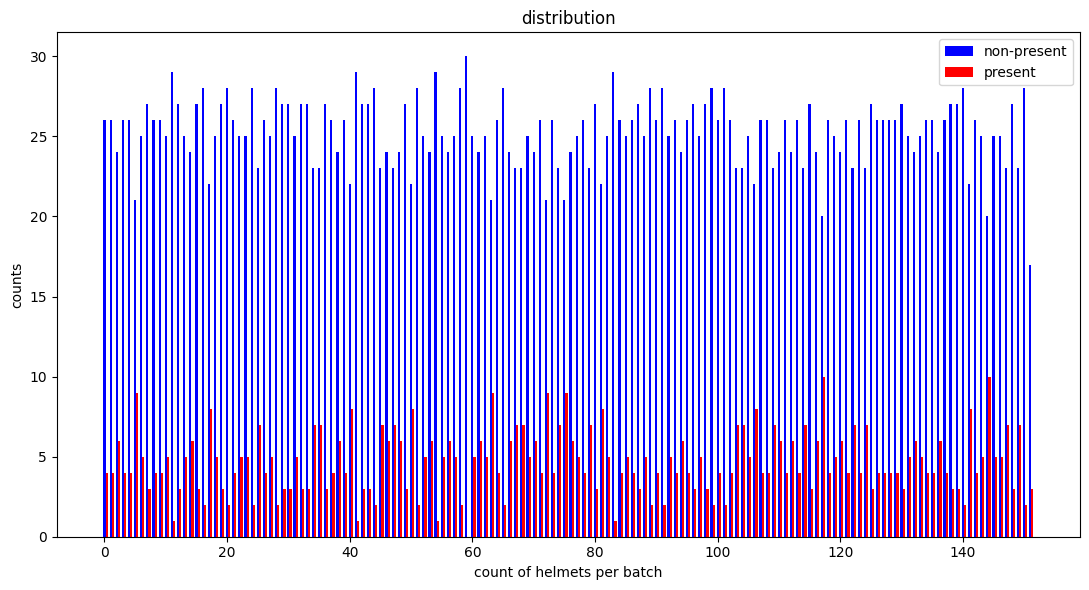

In [36]:
show_detail_hist()

From the graphs above we can see how unbalanced the dataset is, and this leads to biased predictions by the model as shown below. Thereforefore a need for balacing these datasets arises.

In [37]:
# Image Samples
sample_1 = 'helmet_data/cnn_classes/train/helmet non-present/hard_hat_workers149.png'
sample_2 = 'test7.jpg'
sample_3 = 'tes2.jpg'
sample_4 = 'test5.jpg'

sample_list = [sample_1,sample_2,sample_3,sample_4]

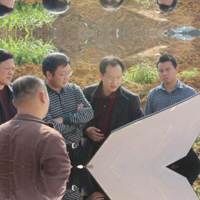

Class 0, A helmet is not present


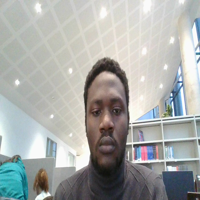

Class 0, A helmet is not present


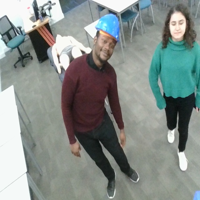

Class 0, A helmet is not present


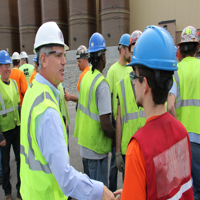

Class 0, A helmet is not present


In [38]:
from PIL import Image
import numpy as np

def show_pred(imgs):
    for image_path in imgs:

        img = Image.open(image_path)

        display(img.resize((200,200)))

        img_tensor = transformer(img)  # We transform the test image through the transformer pipeline 

        img_tensor = img_tensor[np.newaxis, :]

        img_tensor = img_tensor.to(device) 

        pred_prob = cnn_model(img_tensor)  # load the image into the model 

        pred = torch.max(pred_prob,1).indices

        pred = pred.item()
        if pred == 0:
            print(f"Class {pred}, a helmet is present")
        else:
            print(f"Class {pred}, A helmet is not present")

        print("========================================================")
        
show_pred(sample_list)

### Utilising class weights

So there are two solutions that can be done, which could be  oversampling or class weighting.
For class weighting the classes are given weights with respect to the frequency of each of their appearance. For our dataset, we see that the images with non helmets
are far less than the images without helmets.

In [39]:
# Class weighting 
class_weights = [1,5.4]
sample_weights = [0] * len(train_dataset)

for idx,(data,label) in enumerate(train_dataset):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight
    
sampler = WeightedRandomSampler(sample_weights, num_samples = len(sample_weights), replacement = True)

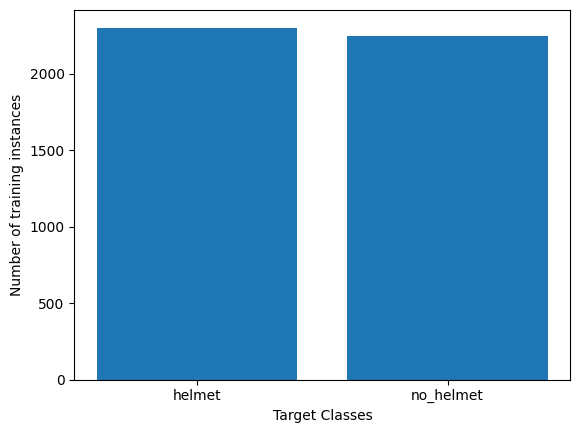

In [40]:
train_loader = DataLoader(train_dataset, batch_size = 30 , num_workers = 2,sampler = sampler)
test_loader = DataLoader(test_dataset,batch_size = 30, shuffle = True, num_workers = 2)

disp_class_hist(train_loader)


100%|██████████| 152/152 [00:18<00:00,  8.20it/s]


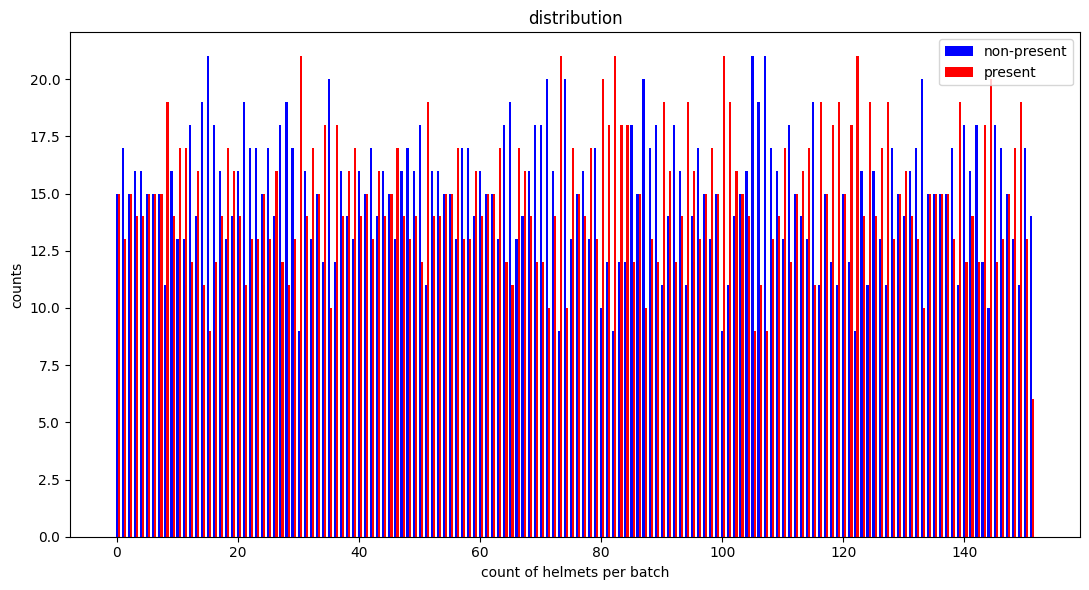

In [41]:
show_detail_hist(train_loader)

100%|██████████| 152/152 [00:20<00:00,  7.43batch/s]


Epoch: 1, Duration: 28.291704893112183
Training_loss: 0.3161134421825409, Test_loss: 0.2976919114589691
,Training_accuracy:0.794945054945055, Test_accuracy: 0.8663148636763413


100%|██████████| 152/152 [00:17<00:00,  8.63batch/s]


Epoch: 2, Duration: 24.543999433517456
Training_loss: 0.5469951629638672, Test_loss: 0.44721123576164246
,Training_accuracy:0.8065934065934066, Test_accuracy: 0.8399296394019349


100%|██████████| 152/152 [00:20<00:00,  7.30batch/s]


Epoch: 3, Duration: 28.15155816078186
Training_loss: 0.44041377305984497, Test_loss: 0.5684553384780884
,Training_accuracy:0.8237362637362637, Test_accuracy: 0.7387862796833773


100%|██████████| 152/152 [00:21<00:00,  7.23batch/s]


Epoch: 4, Duration: 28.39955163002014
Training_loss: 0.5780585408210754, Test_loss: 0.71504807472229
,Training_accuracy:0.8283516483516483, Test_accuracy: 0.8944591029023746


100%|██████████| 152/152 [00:20<00:00,  7.42batch/s]


Epoch: 5, Duration: 27.827368021011353
Training_loss: 0.33640164136886597, Test_loss: 0.27982017397880554
,Training_accuracy:0.8259340659340659, Test_accuracy: 0.8460861917326298


100%|██████████| 152/152 [00:20<00:00,  7.56batch/s]


Epoch: 6, Duration: 26.966139554977417
Training_loss: 0.13918215036392212, Test_loss: 0.37792566418647766
,Training_accuracy:0.8360439560439561, Test_accuracy: 0.8478452066842568


100%|██████████| 152/152 [00:18<00:00,  8.12batch/s]


Epoch: 7, Duration: 26.34557271003723
Training_loss: 0.6036628484725952, Test_loss: 0.4402160942554474
,Training_accuracy:0.8457142857142858, Test_accuracy: 0.8557607739665787


100%|██████████| 152/152 [00:20<00:00,  7.38batch/s]


Epoch: 8, Duration: 27.84224820137024
Training_loss: 0.3442882299423218, Test_loss: 0.4149218201637268
,Training_accuracy:0.8430769230769231, Test_accuracy: 0.8680738786279684


100%|██████████| 152/152 [00:18<00:00,  8.11batch/s]


Epoch: 9, Duration: 25.551530361175537
Training_loss: 0.14276185631752014, Test_loss: 0.34072959423065186
,Training_accuracy:0.8351648351648352, Test_accuracy: 0.8979771328056289


100%|██████████| 152/152 [00:19<00:00,  7.71batch/s]


Epoch: 10, Duration: 26.655447244644165
Training_loss: 0.2635659873485565, Test_loss: 0.29496175050735474
,Training_accuracy:0.8417582417582418, Test_accuracy: 0.8188214599824098


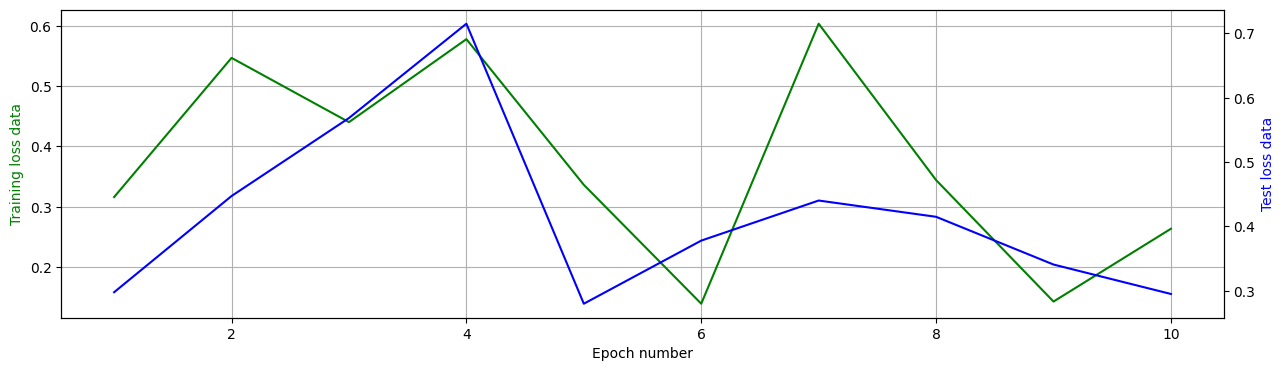

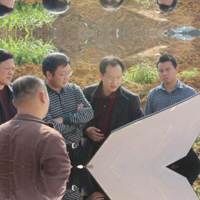

Class 1, a helmet is present


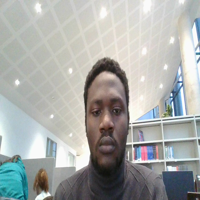

Class 1, a helmet is present


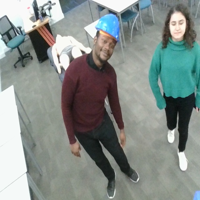

Class 1, a helmet is present


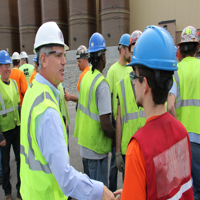

Class 0, A helmet is not present


In [42]:
metrics = train_eval_cnn()
show_metrics(metrics)
show_pred(sample_list)

### Augmenting the dataset

The other method is to use augmentation. Now by using the augmentations, the number of images for the non helmet dataset will be able to be balanced with that of the class with helmets. For CNN models, it helps  

In [43]:
import albumentations as A

def make_augmentations():
    '''
    The augmentation process will help increase the number of pictures in the non-helmet category.
    The probability towards rotation of the pictures will also be high so it can cover up for 
    the limitations concerning the CNN algorithm.
    
    '''
    
    augmentor = A.Compose([A.RandomCrop(width=180, height=180), #Creating the augmentation pipeline
                             A.HorizontalFlip(p=0.7), 
                             A.RandomBrightnessContrast(p=0.2),
                             A.RandomGamma(p=0.25), 
                             A.RGBShift(p=0.15), 
                             A.VerticalFlip(p=0.7)]) 
    

    cnn_n_hel_tr = os.path.join('final_dataset','train', 'no_helmet_train') # This is the path for the train folder containing non-helmet pictures
    for image in tqdm(os.listdir(cnn_n_hel_tr)):
        img = cv2.imread(os.path.join(cnn_n_hel_tr, image))

        for x in range(5):
            augmented_image = augmentor(image=img)['image']
            cv2.imwrite(os.path.join(cnn_n_hel_tr , f'{image.split(".")[0]}.{x}.jpg'),augmented_image)
make_augmentations()

In [44]:
train_loader = DataLoader(train_dataset, batch_size = 30 ,shuffle = True, num_workers = 2,)
test_loader = DataLoader(test_dataset,batch_size = 30, shuffle = True, num_workers = 2)

100%|██████████| 152/152 [00:23<00:00,  6.36batch/s]


Epoch: 1, Duration: 30.926770210266113
Training_loss: 0.3177120089530945, Test_loss: 0.20451620221138
,Training_accuracy:0.9186813186813186, Test_accuracy: 0.9270008795074758


100%|██████████| 152/152 [00:22<00:00,  6.63batch/s]


Epoch: 2, Duration: 29.814371585845947
Training_loss: 0.04119713231921196, Test_loss: 0.23916533589363098
,Training_accuracy:0.9204395604395604, Test_accuracy: 0.9270008795074758


100%|██████████| 152/152 [00:22<00:00,  6.75batch/s]


Epoch: 3, Duration: 29.828283548355103
Training_loss: 0.13737806677818298, Test_loss: 0.3404809236526489
,Training_accuracy:0.9217582417582417, Test_accuracy: 0.9287598944591029


100%|██████████| 152/152 [00:21<00:00,  7.00batch/s]


Epoch: 4, Duration: 28.80210304260254
Training_loss: 0.3913060128688812, Test_loss: 0.2376878410577774
,Training_accuracy:0.9228571428571428, Test_accuracy: 0.9217238346525946


100%|██████████| 152/152 [00:21<00:00,  6.93batch/s]


Epoch: 5, Duration: 28.697269439697266
Training_loss: 0.30764636397361755, Test_loss: 0.38193297386169434
,Training_accuracy:0.9210989010989011, Test_accuracy: 0.9287598944591029


100%|██████████| 152/152 [00:22<00:00,  6.73batch/s]


Epoch: 6, Duration: 30.894760847091675
Training_loss: 0.10331638157367706, Test_loss: 0.23590704798698425
,Training_accuracy:0.9206593406593406, Test_accuracy: 0.9270008795074758


100%|██████████| 152/152 [00:25<00:00,  6.02batch/s]


Epoch: 7, Duration: 31.782506465911865
Training_loss: 0.1678401529788971, Test_loss: 0.09481553733348846
,Training_accuracy:0.9235164835164835, Test_accuracy: 0.9278803869832893


100%|██████████| 152/152 [00:22<00:00,  6.72batch/s]


Epoch: 8, Duration: 29.740588665008545
Training_loss: 0.17325259745121002, Test_loss: 0.2327071875333786
,Training_accuracy:0.9235164835164835, Test_accuracy: 0.9331574318381706


100%|██████████| 152/152 [00:23<00:00,  6.56batch/s]


Epoch: 9, Duration: 30.882937908172607
Training_loss: 0.14920786023139954, Test_loss: 0.11815201491117477
,Training_accuracy:0.9239560439560439, Test_accuracy: 0.93051890941073


100%|██████████| 152/152 [00:23<00:00,  6.38batch/s]


Epoch: 10, Duration: 30.50369358062744
Training_loss: 0.48988962173461914, Test_loss: 0.0970863476395607
,Training_accuracy:0.9243956043956044, Test_accuracy: 0.93051890941073


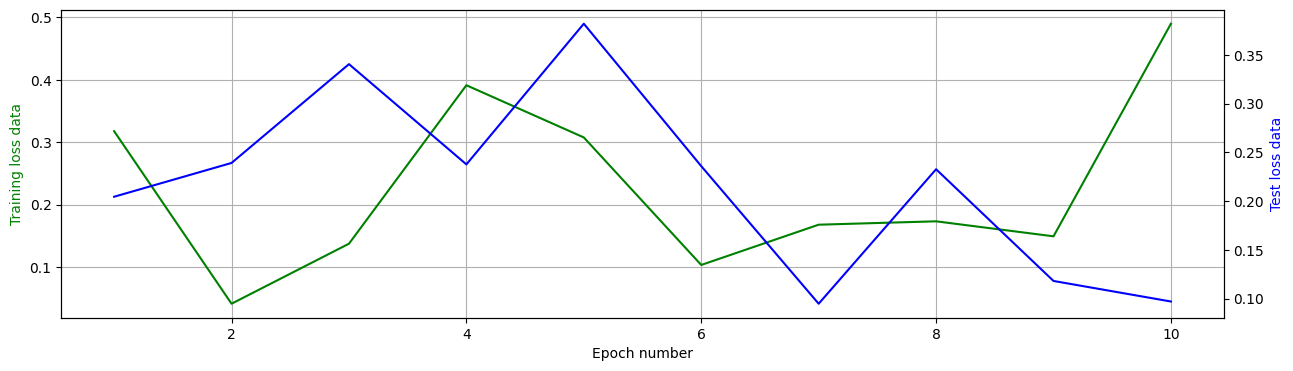

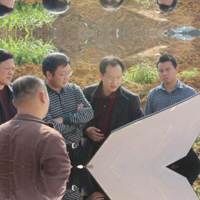

Class 0, A helmet is not present


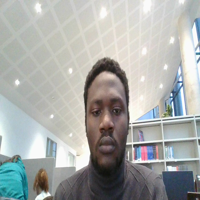

Class 1, a helmet is present


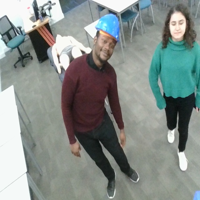

Class 0, A helmet is not present


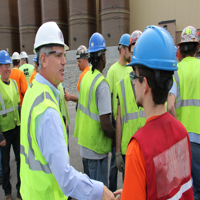

Class 0, A helmet is not present


In [45]:
metrics = train_eval_cnn(train_loader)
show_metrics(metrics)
show_pred(sample_list)

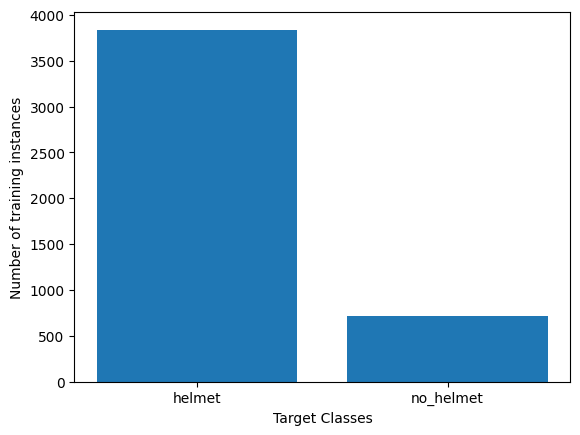

In [46]:
disp_class_hist(train_loader)

100%|██████████| 152/152 [00:20<00:00,  7.48it/s]


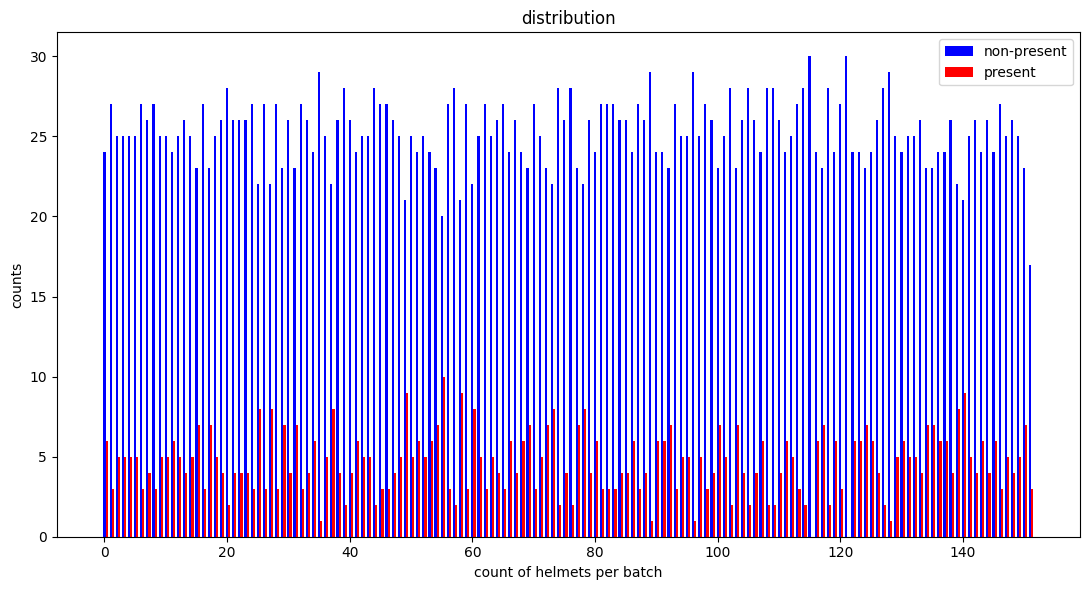

In [47]:
show_detail_hist(train_loader)

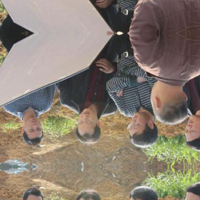

Class 0, A helmet is not present


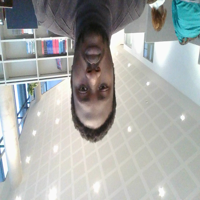

Class 1, a helmet is present


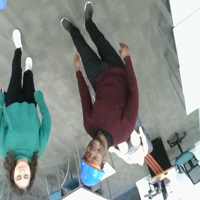

Class 0, A helmet is not present


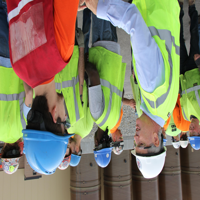

Class 0, A helmet is not present


In [48]:
for image_path in sample_list:
    
    img = Image.open(image_path)
    
    
    img= img.rotate(180)
    img.save('img.jpg')
    
    display(img.resize((200,200)))
    
    img_tensor = transformer(img)  # We transform the test image through the transformer pipeline 
    
    img_tensor = img_tensor[np.newaxis, :]
    
    img_tensor = img_tensor.to(device) 
    
    pred_prob = cnn_model(img_tensor)  # load the image into the model 
    
    pred = torch.max(pred_prob,1).indices
    
    pred = pred.item()
    if pred == 1:
        print(f"Class {pred}, a helmet is present")
    else:
        print(f"Class {pred}, A helmet is not present")

    print("========================================================")

## Object detection using the cnn

In [ ]:
#https://www.educative.io/answers/how-to-capture-a-single-photo-with-webcam-using-opencv-in-python
def take_picture()
    import cv2

    # intialize the webcam and pass a constant which is 0
    cam = cv2.VideoCapture(0)

    # title of the app
    cv2.namedWindow('CNN tester')

    # let's assume the number of images gotten is 0
    img_counter = 0

    # while loop
    while True:
        # intializing the frame, ret
        ret, frame = cam.read()
        # if statement
        if not ret:
            print('failed to grab frame')
            break
        # the frame will show with the title of test
        cv2.imshow('test', frame)
        #to get continuous live video feed from my laptops webcam
        k  = cv2.waitKey(1)
        # if the escape key is been pressed, the app will stop
        if k%256 == 27:
            print('escape hit, closing the app')
            break
        # if the spacebar key is been pressed
        # screenshots will be taken
        elif k%256  == 32:
            # the format for storing the images scrreenshotted
            img_name = f'opencv_frame_{img_counter}.jpg'
            # saves the image as a png file
            cv2.imwrite(img_name, frame)
            print('screenshot taken')
            # the number of images automaticallly increases by 1
            img_counter += 1

    # release the camera
    cam.release()

    # stops the camera window
    cv2.destroyAllWindows()

    

In [ ]:
img = Image.open('opencv_frame_0.jpg')

display(img.resize((200,200)))

img_tensor = transformer(img)  # We transform the test image through the transformer pipeline 

img_tensor = img_tensor[np.newaxis, :]

img_tensor = img_tensor.to(device) 

pred_prob = cnn_model(img_tensor)  # load the image into the model 

pred = torch.max(pred_prob,1).indices

pred = pred.item()
if pred == 1:
    print(f"Class {pred}, a helmet is present")
else:
    print(f"Class {pred}, A helmet is not present")

### References  

 

*  OSHA. (n.d.). Personal Protective Equipment. Retrieved from https://www.osha.gov/personal-protective-equipment 

*  Aqeel Anwar (2019). Difference between AlexNet, VGGNet, ResNet and Inception. [online] Medium. Available at: https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96. 

 

*  Du, J., 2018, April. Understanding of object detection based on CNN family and YOLO. In Journal of Physics: Conference Series (Vol. 1004, p. 012029). IOP Publishing. 

 

*  Redmon, J., Divvala, S., Girshick, R. and Farhadi, A., 2016. You only look once: Unified, real-time object detection. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 779-788). 

 

*  Gandhi, R. (2018). R-CNN, Fast R-CNN, Faster R-CNN, YOLO — Object Detection Algorithms. [online] Towards Data Science. Available at: https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e. 

 

 

*  Hayat, A. and Morgado-Dias, F., 2022. Deep learning-based automatic safety helmet detection system for construction safety. Applied Sciences, 12(16), p.8268. 

 

*  OpenGenus IQ: Computing Expertise & Legacy. (2021). ReLU (Rectified Linear Unit) Activation Function. [online] Available at: https://iq.opengenus.org/relu-activation/. 

 